# EAS: Entrenamiento

El objetivo de este trabajo es la localización y segmentación de **paneles fotovoltaicos y colectores solares.**

Como datos iniciales, se recopiló una lista de puntos georreferenciados (aproximados) de paneles y colectores, y a partir de estos, se tomó una muestra y se marcaron polígonos de paneles y colectores. Los polígonos delimitan el contorno de los objetos de interés.

El método de análisis y predicción está dado por el modelo de machine learning **U-Net**, especializado en **segmentación semántica**, por lo tanto se requieren anotaciones de polígonos.

**En estos notebooks se va a hacer foco principalmente en los modelos para la detección de paneles.** Se exploró la detección y clasificación de colectores solares en el notebook [5 - Colectores](5_Colectores.ipynb).

## Preparación de datos

Los datos de entrenamiento se componen de dos partes: las imágenes y las máscaras. Las máscaras marcan la región de interés de cada imagen. Por ejemplo, marca donde hay un conjunto de módulos de paneles. Cada imagen debe poseer su correspondiente máscara.

![](img/sample_chip_mask.jpg)

Como el objetivo era analizar toda la cobertura a nivel nacional, pero también aprovechar la mayor resolución espacial de la ortoimagen urbana, se entrenaron dos modelos:

1. **Modelo 1: Urbana** - basado en la ortoimagen urbana de 10cm
2. **Modelo 2: Nacional** - basado en la ortoimagen nacional de 30cm

Para entrenar cada uno de los modelos, vamos a descargar imágenes tanto de la ortoimagen nacional como la urbana. Aprovechando que `ideuy` nos permite descargar sólo las imágenes que necesitamos para el entrenamiento, utilizaremos el mismo shapefile de anotaciones para filtrar la grilla urbana y nacional y descargar sólo esas hojas.

Los archivos vectoriales de anotaciones se encuentran en `data/paneles/shp/` y son:

* `paneles_nac_pol.geojson`: Paneles en cobertura nacional
* `paneles_urb_pol.geojson`: Paneles en cobertura urbana
* `paneles_nacurb_pol.geojson`: La unión de los dos anteriores GeoJSONs

El tercer GeoJSON es la unión de los dos anteriores, y va a ser utilizada por el modelo 2.

In [2]:
DATA_DIR = "data/paneles"

In [23]:
!ls $DATA_DIR/shp

paneles_nac_pol.geojson  paneles_nacurb_pol.geojson  paneles_urb_pol.geojson


In [3]:
# Instalamos ideuy
!pip install -U ideuy

     |████████████████████████████████| 503 kB 3.4 MB/s eta 0:00:01


In [4]:
# Reproyectamos a epsg:5381 (requerimiento de ideuy_filter)
!ogr2ogr -f GeoJSON -t_srs epsg:5381 /tmp/paneles_urb_pol_5381.geojson $DATA_DIR/shp/paneles_urb_pol.geojson 
!ogr2ogr -f GeoJSON -t_srs epsg:5381 /tmp/paneles_nacurb_pol_5381.geojson $DATA_DIR/shp/paneles_nacurb_pol.geojson 

Warning 1: Several features with id = 1 have been found. Altering it to be unique. This warning will not be emitted for this layer


In [5]:
# Generamos la grilla filtrada para urbano
!ideuy_filter -t urban \
              -o /tmp/paneles_urb_grilla.geojson \
              -v \
              /tmp/paneles_urb_pol_5381.geojson

In [6]:
# ...y para nacional
!ideuy_filter -t national \
              -o /tmp/paneles_nacurb_grilla.geojson \
              -v \
              /tmp/paneles_nacurb_pol_5381.geojson

In [7]:
# Descargamos las hojas de la imagen urbana
!ideuy_download \
    -t urban \
    -p rgb_8bit \
    -j4 \
    -v \
    -o $DATA_DIR/train/urban/raw_images \
    /tmp/paneles_urb_grilla.geojson

  0%|                                                    | 0/42 [00:00<?, ?it/s][2020-10-14 20:54:19] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_04/02_Ortoimagenes/04_Ciudad_LPS/03_RGB_8bits/K29B2N9_RGB_8_Remesa_04_LPS.jpg to data/paneles/urban/raw_images
[2020-10-14 20:54:19] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/K29B5M3_RGB_8_Remesa_01_MVD.jpg to data/paneles/urban/raw_images
[2020-10-14 20:54:19] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/K29B5N1_RGB_8_Remesa_01_MVD.jpg to data/paneles/urban/raw_images
[2020-10-14 20:54:19] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/K29B5P9_RGB_8_Remesa_01_MVD.jpg to data/paneles/urban/raw_images
[2020-10-14 20:54:22] INFO:ideuy.download:Download https

[2020-10-14 20:54:28] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/J29C1O8_RGB_8_Remesa_01_MVD.jgw to data/paneles/urban/raw_images
[2020-10-14 20:54:28] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/J29C4N5_RGB_8_Remesa_01_MVD.jgw to data/paneles/urban/raw_images
[2020-10-14 20:54:29] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/J29C4M8_RGB_8_Remesa_01_MVD.jgw to data/paneles/urban/raw_images
[2020-10-14 20:54:29] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_01/02_Ortoimagenes/01_Ciudad_MVD/03_RGB_8bits/J29C5M2_RGB_8_Remesa_01_MVD.jpg to data/paneles/urban/raw_images
 40%|█████████████████▍                         | 17/42 [00:10<00:17,  1.40it/s][2020-10-14 20:54:29] INFO:ideuy.download:Download https

 76%|████████████████████████████████▊          | 32/42 [00:16<00:04,  2.37it/s][2020-10-14 20:54:35] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_07/02_Ortoimagenes/13_Ciudad_SJM/03_RGB_8bits/L26C6N3_RGB_8_Remesa_07_SJM.jgw to data/paneles/urban/raw_images
[2020-10-14 20:54:35] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_08/02_Ortoimagenes/06_Ciudad_NPA/03_RGB_8bits/R24B2P1_RGB_8_Remesa_08_NPA.jpg to data/paneles/urban/raw_images
 79%|█████████████████████████████████▊         | 33/42 [00:16<00:03,  2.58it/s][2020-10-14 20:54:35] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_08/02_Ortoimagenes/05_Ciudad_MER/03_RGB_8bits/P20D2P8_RGB_8_Remesa_08_MER.jgw to data/paneles/urban/raw_images
[2020-10-14 20:54:36] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CU_Remesa_08/02_Ortoimagenes/05_Ciudad_MER/03_RGB_8bits/P20D5N3_RGB_8_Remesa_08_MER.jgw to data/p

In [8]:
# ...y las de la imagen nacional
!ideuy_download \
    -t national \
    -p rgb_8bit \
    -j4 \
    -v \
    -o $DATA_DIR/train/national/raw_images \
    /tmp/paneles_nacurb_grilla.geojson

  0%|                                                    | 0/60 [00:00<?, ?it/s][2020-10-14 20:54:40] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_08/02_Ortoimagenes/03_RGB_8bits/E13D2_RGB_8_Remesa_08.jpg to data/paneles/national/raw_images
[2020-10-14 20:54:40] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_10/02_Ortoimagenes/03_RGB_8bits/N10C4_RGB_8_Remesa_10.jpg to data/paneles/national/raw_images
[2020-10-14 20:54:40] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_03/02_Ortoimagenes/03_RGB_8bits/O20A1_RGB_8_Remesa_03.jpg to data/paneles/national/raw_images
[2020-10-14 20:54:40] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_03/02_Ortoimagenes/03_RGB_8bits/P25D6_RGB_8_Remesa_03.jpg to data/paneles/national/raw_images
[2020-10-14 20:54:41] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_10/02_Ortoimagenes/

[2020-10-14 20:54:47] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_03/02_Ortoimagenes/03_RGB_8bits/P22A5_RGB_8_Remesa_03.jgw to data/paneles/national/raw_images
[2020-10-14 20:54:48] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_03/02_Ortoimagenes/03_RGB_8bits/O24A4_RGB_8_Remesa_03.jpg to data/paneles/national/raw_images
 32%|█████████████▌                             | 19/60 [00:08<00:13,  2.96it/s][2020-10-14 20:54:49] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_01/02_Ortoimagenes/03_RGB_8bits/K29A6_RGB_8_Remesa_01.jgw to data/paneles/national/raw_images
[2020-10-14 20:54:49] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_03/02_Ortoimagenes/03_RGB_8bits/O24A4_RGB_8_Remesa_03.jgw to data/paneles/national/raw_images
[2020-10-14 20:54:49] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_03/02_Ortoimagenes/

 58%|█████████████████████████                  | 35/60 [00:14<00:09,  2.66it/s][2020-10-14 20:54:55] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_10/02_Ortoimagenes/03_RGB_8bits/L09C1_RGB_8_Remesa_10.jgw to data/paneles/national/raw_images
[2020-10-14 20:54:55] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_10/02_Ortoimagenes/03_RGB_8bits/O10A1_RGB_8_Remesa_10.jgw to data/paneles/national/raw_images
[2020-10-14 20:54:55] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_06/02_Ortoimagenes/03_RGB_8bits/J29A6_RGB_8_Remesa_06.jgw to data/paneles/national/raw_images
[2020-10-14 20:54:55] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_10/02_Ortoimagenes/03_RGB_8bits/O10A4_RGB_8_Remesa_10.jgw to data/paneles/national/raw_images
[2020-10-14 20:54:56] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_01/02_Ortoimagenes/

 87%|█████████████████████████████████████▎     | 52/60 [00:22<00:04,  1.71it/s][2020-10-14 20:55:02] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_03/02_Ortoimagenes/03_RGB_8bits/O20B4_RGB_8_Remesa_03.jpg to data/paneles/national/raw_images
[2020-10-14 20:55:02] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_03/02_Ortoimagenes/03_RGB_8bits/O20B2_RGB_8_Remesa_03.jpg to data/paneles/national/raw_images
 92%|███████████████████████████████████████▍   | 55/60 [00:22<00:01,  2.87it/s][2020-10-14 20:55:03] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_08/02_Ortoimagenes/03_RGB_8bits/J12A3_RGB_8_Remesa_08.jgw to data/paneles/national/raw_images
[2020-10-14 20:55:03] INFO:ideuy.download:Download https://visualizador.ide.uy/descargas/datos/CN_Remesa_03/02_Ortoimagenes/03_RGB_8bits/O20B4_RGB_8_Remesa_03.jgw to data/paneles/national/raw_images
[2020-10-14 20:55:03] INFO:ideuy.download:Do

Una vez que haya terminado los dos procesos, deberíamos tener en el directorio `urban` y `national`, un directorio `raw_images` con las imágenes "crudas" de cada ortoimagen.

Estructura de directorios:
```
data/paneles/train/
├── national
│   └── raw_images
└── urban
    └── raw_images
```

## Preprocesamiento


La generacion de las imagenes y mascaras se realiza vía *meduy_extract_chips*. Esta herramienta se utiliza tanto en la generación del dataset de entrenamiento como en el de predicción. En el primer caso se generan las imagenes y las mascaras, y en el segundo sólo las imagenes.

Primero, reproyectamos el geojson de anotaciones a epsg:5382, el mismo CRS que las imágenes.

In [17]:
!ogr2ogr -f GeoJSON -t_srs epsg:5382 \
    /tmp/paneles_urb_pol_5382.geojson \
    $DATA_DIR/shp/paneles_urb_pol.geojson 

!ogr2ogr -f GeoJSON -t_srs epsg:5382 \
    /tmp/paneles_nacurb_pol_5382.geojson \
    $DATA_DIR/shp/paneles_nacurb_pol.geojson     

Warning 1: Several features with id = 1 have been found. Altering it to be unique. This warning will not be emitted for this layer


Ahora, ejecutamos `meduy_extract_chips` para generar chips. Para cada modelo generamos chips de distinto tamaño, dado que las imagenes tienen diferente resolución. Despues de evaluar varios tamaños encontramos que los siguientes valores son óptimos para las imagenes y este problema:

* Urbano: 400px
* Nacional: 160px

Además, al entrenar, generamos chips con solapamiento para tener más información a la hora de entrenar, y para asegurarnos que el modelo entrene bien cuando los objetos queden en los bordes de la imagen.

* Urbano: 100px
* Nacional: 40px

Por otro lado, luego de varias pruebas, para el modelo 2 se decidió sumar las anotaciones de cobertura urbana. Por ende, para el modelo 2, se generaron chips usando los dos geojsons sobre las imagenes de cobertura nacional.

In [31]:
# Chips para entrenar modelo 1
!meduy_extract_chips \
    $DATA_DIR/train/urban/raw_images/*.jpg \
    $DATA_DIR/train/urban/raw_images/*.jp2 \
    -o $DATA_DIR/train/urban/400_100/ \
    --size 400 \
    --step-size 100 \
    --crs epsg:5382 \
    --labels /tmp/paneles_urb_pol_5382.geojson \
    --aoi /tmp/paneles_urb_pol_5382.geojson \
    -v

[2020-10-14 22:06:18] INFO:meduy.console.extract_chips:No rescale intensity
[2020-10-14 22:06:18] INFO:meduy.console.extract_chips:Extract chips
[2020-10-14 22:06:18] INFO:meduy.chips:Prepare AOI shape
[2020-10-14 22:06:18] INFO:meduy.chips:Prepare label shapes
  0%|                                                    | 0/42 [00:00<?, ?it/s][2020-10-14 22:06:18] INFO:meduy.chips:Raster size: (10307, 9508)
[2020-10-14 22:06:18] INFO:meduy.chips:Building windows
[2020-10-14 22:06:18] INFO:meduy.chips:Total windows: 9200
[2020-10-14 22:06:18] INFO:meduy.chips:Building window shapes
[2020-10-14 22:06:18] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:06:18] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:06:18] INFO:meduy.chips:Total windows after filtering: 34

  2%|█                                           | 1/42 [00:03<02:09,  3.17s/it][2020-10-14 22:06:21] INFO:meduy.chips:Raster size: (10253, 9429)
[2020-10-14 22:06:21] INFO:meduy.chips:Building windows
[2020-10

 24%|██████████▏                                | 10/42 [00:47<02:51,  5.35s/it][2020-10-14 22:07:06] INFO:meduy.chips:Raster size: (10225, 9409)
[2020-10-14 22:07:06] INFO:meduy.chips:Building windows
[2020-10-14 22:07:06] INFO:meduy.chips:Total windows: 9009
[2020-10-14 22:07:06] INFO:meduy.chips:Building window shapes
[2020-10-14 22:07:06] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:07:06] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:07:06] INFO:meduy.chips:Total windows after filtering: 129

 26%|███████████▎                               | 11/42 [00:52<02:37,  5.09s/it][2020-10-14 22:07:10] INFO:meduy.chips:Raster size: (10226, 9410)
[2020-10-14 22:07:10] INFO:meduy.chips:Building windows
[2020-10-14 22:07:10] INFO:meduy.chips:Total windows: 9009
[2020-10-14 22:07:10] INFO:meduy.chips:Building window shapes
[2020-10-14 22:07:10] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:07:10] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:07

[2020-10-14 22:07:46] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:07:46] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:07:46] INFO:meduy.chips:Total windows after filtering: 126

 52%|██████████████████████▌                    | 22/42 [01:32<01:16,  3.81s/it][2020-10-14 22:07:50] INFO:meduy.chips:Raster size: (10212, 9387)
[2020-10-14 22:07:50] INFO:meduy.chips:Building windows
[2020-10-14 22:07:50] INFO:meduy.chips:Total windows: 8910
[2020-10-14 22:07:50] INFO:meduy.chips:Building window shapes
[2020-10-14 22:07:50] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:07:50] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:07:51] INFO:meduy.chips:Total windows after filtering: 43

 55%|███████████████████████▌                   | 23/42 [01:34<01:05,  3.44s/it][2020-10-14 22:07:53] INFO:meduy.chips:Raster size: (10210, 9389)
[2020-10-14 22:07:53] INFO:meduy.chips:Building windows
[2020-10-14 22:07:53] INFO:meduy.chips:Total windows: 8910
[2020

[2020-10-14 22:08:24] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:08:24] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:08:24] INFO:meduy.chips:Total windows after filtering: 25

 79%|█████████████████████████████████▊         | 33/42 [02:07<00:26,  2.91s/it][2020-10-14 22:08:25] INFO:meduy.chips:Raster size: (10223, 9343)
[2020-10-14 22:08:25] INFO:meduy.chips:Building windows
[2020-10-14 22:08:25] INFO:meduy.chips:Total windows: 8910
[2020-10-14 22:08:25] INFO:meduy.chips:Building window shapes
[2020-10-14 22:08:26] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:08:26] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:08:26] INFO:meduy.chips:Total windows after filtering: 81

 81%|██████████████████████████████████▊        | 34/42 [02:12<00:28,  3.56s/it][2020-10-14 22:08:31] INFO:meduy.chips:Raster size: (10223, 9344)
[2020-10-14 22:08:31] INFO:meduy.chips:Building windows
[2020-10-14 22:08:31] INFO:meduy.chips:Total windows: 8910
[2020-

Los argumentos del comando son:

* **El primer argumento** es la ruta a las imágenes. Notar que le pasamos `*.jpg` y `\*.jp2`, esto es porque algunas imágenes de IDE están en formato JPEG2000, no JPG, y su extensión es `.jp2`, pero ambos formatos son válidos.*

* **-o** es la ruta del directorio destino. Recomendamos que dicha ruta sea descriptiva, por ejemplo `data_train/chips/400_100/Remesa08/ ” describe : `data_train` → datos usados para entrenar; `400_100` → `<tamaño de la imagen>_<tamaño del step_size>` (las imágenes son cuadradas); `Remesa08` → Remesa sobre la que vamos a trabajar.

* **--size** tamaño de las imágenes resultantes (las imágenes siempre son cuadradas) 
* **--step-size** paso del proceso. Si *step_size* es igual que el *size* entonces no hay overlap en las imágenes. 

En ocaciones es útil para el entrenamiento generar los chips con un overlap de este modo tenemos más datos para entrenar. Como mencionamos antes, para urbano hacemos 100px y 40px de overlap respectivamente. En la predicción valor puede ser igual al tamaño que la imagen, dado que con eso alcanza para cubrir toda la imagen entera.

* **--crs** le asigna un epsg a la imagen resultado. Para las imágenes del vuelo siempre debe ser `epsg:5382`. Esto es sólo necesario para las imágenes de formato JPG/JPEG2000, dado que no tienen CRS asociado.

* **--label-property** nombre de la columna donde se define cada categoría en el archivo vectorial (sólo se usa en el entrenamiento).

* **--classes** nombres de las clases (como aparecen en el geojson), separados por espacios.

* **--aoi** ruta al archivo vectorial con los polígonos de los paneles. Al definir una región de interes, sólo se procesan las imagenes que interceptan con los paneles. Es decir, no se generarán chips donde no haya paneles.

Este comando va a generar dos carpetas en la ruta de destino : "images" y "masks". Los archivos de la primera van a ser de tipo Tiff de 3 bandas (RGB) y los de la segunda van a ser también de tipo Tiff, pero de N bandas donde N representa el número de clases, en este caso 1, porque solo estamos interesados en segmentar paneles. Esta imagen de una banda es una máscara binaria.

In [32]:
# Chips para entrenar modelo 2
!meduy_extract_chips \
    $DATA_DIR/train/national/raw_images/*.jpg \
    -o $DATA_DIR/train/national/160_40/ \
    --size 160 \
    --step-size 40 \
    --crs epsg:5382 \
    --labels /tmp/paneles_nacurb_pol_5382.geojson \
    --aoi /tmp/paneles_nacurb_pol_5382.geojson \
    -v

[2020-10-14 22:10:28] INFO:meduy.console.extract_chips:No rescale intensity
[2020-10-14 22:10:28] INFO:meduy.console.extract_chips:Extract chips
[2020-10-14 22:10:28] INFO:meduy.chips:Prepare AOI shape
[2020-10-14 22:10:28] INFO:meduy.chips:Prepare label shapes
  0%|                                                    | 0/59 [00:00<?, ?it/s][2020-10-14 22:10:28] INFO:meduy.chips:Raster size: (19092, 17012)
[2020-10-14 22:10:28] INFO:meduy.chips:Building windows
[2020-10-14 22:10:29] INFO:meduy.chips:Total windows: 200028
[2020-10-14 22:10:29] INFO:meduy.chips:Building window shapes
[2020-10-14 22:10:31] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:10:31] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:10:37] INFO:meduy.chips:Total windows after filtering: 70

  2%|▋                                           | 1/59 [00:17<17:23, 17.99s/it][2020-10-14 22:10:46] INFO:meduy.chips:Raster size: (18449, 16954)
[2020-10-14 22:10:46] INFO:meduy.chips:Building windows
[202

[2020-10-14 22:12:26] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:12:26] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:12:41] INFO:meduy.chips:Total windows after filtering: 24

 10%|████▍                                       | 6/59 [02:17<20:45, 23.51s/it][2020-10-14 22:12:46] INFO:meduy.chips:Raster size: (18911, 16749)
[2020-10-14 22:12:46] INFO:meduy.chips:Building windows
[2020-10-14 22:12:46] INFO:meduy.chips:Total windows: 194635
[2020-10-14 22:12:46] INFO:meduy.chips:Building window shapes
[2020-10-14 22:12:49] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:12:49] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:13:04] INFO:meduy.chips:Total windows after filtering: 16

 12%|█████▏                                      | 7/59 [02:43<21:07, 24.38s/it][2020-10-14 22:13:12] INFO:meduy.chips:Raster size: (18305, 16765)
[2020-10-14 22:13:12] INFO:meduy.chips:Building windows
[2020-10-14 22:13:13] INFO:meduy.chips:Total windows: 188864


 19%|████████                                   | 11/59 [04:53<23:15, 29.08s/it][2020-10-14 22:15:22] INFO:meduy.chips:Raster size: (18278, 16755)
[2020-10-14 22:15:22] INFO:meduy.chips:Building windows
[2020-10-14 22:15:22] INFO:meduy.chips:Total windows: 187995
[2020-10-14 22:15:22] INFO:meduy.chips:Building window shapes
[2020-10-14 22:15:25] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:15:25] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:15:39] INFO:meduy.chips:Total windows after filtering: 92

 20%|████████▋                                  | 12/59 [05:22<22:39, 28.93s/it][2020-10-14 22:15:50] INFO:meduy.chips:Raster size: (18626, 16675)
[2020-10-14 22:15:50] INFO:meduy.chips:Building windows
[2020-10-14 22:15:51] INFO:meduy.chips:Total windows: 190806
[2020-10-14 22:15:51] INFO:meduy.chips:Building window shapes
[2020-10-14 22:15:53] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:15:53] INFO:meduy.chips:Using "intersects" function
[2020-10-14 

[2020-10-14 22:17:30] INFO:meduy.chips:Total windows after filtering: 40

 27%|███████████▋                               | 16/59 [07:05<19:03, 26.58s/it][2020-10-14 22:17:34] INFO:meduy.chips:Raster size: (18248, 16704)
[2020-10-14 22:17:34] INFO:meduy.chips:Building windows
[2020-10-14 22:17:34] INFO:meduy.chips:Total windows: 187542
[2020-10-14 22:17:34] INFO:meduy.chips:Building window shapes
[2020-10-14 22:17:37] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:17:37] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:17:51] INFO:meduy.chips:Total windows after filtering: 20

 29%|████████████▍                              | 17/59 [07:35<19:19, 27.61s/it][2020-10-14 22:18:04] INFO:meduy.chips:Raster size: (18277, 16724)
[2020-10-14 22:18:04] INFO:meduy.chips:Building windows
[2020-10-14 22:18:04] INFO:meduy.chips:Total windows: 187995
[2020-10-14 22:18:04] INFO:meduy.chips:Building window shapes
[2020-10-14 22:18:07] INFO:meduy.chips:Filtering windows by AOI
[2020

 31%|█████████████                              | 18/59 [08:16<21:36, 31.62s/it][2020-10-14 22:18:45] INFO:meduy.chips:Raster size: (18258, 16714)
[2020-10-14 22:18:45] INFO:meduy.chips:Building windows
[2020-10-14 22:18:45] INFO:meduy.chips:Total windows: 187542
[2020-10-14 22:18:45] INFO:meduy.chips:Building window shapes
[2020-10-14 22:18:48] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:18:48] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:19:02] INFO:meduy.chips:Total windows after filtering: 16

 32%|█████████████▊                             | 19/59 [08:36<18:47, 28.18s/it][2020-10-14 22:19:05] INFO:meduy.chips:Raster size: (18268, 16724)
[2020-10-14 22:19:05] INFO:meduy.chips:Building windows
[2020-10-14 22:19:05] INFO:meduy.chips:Total windows: 187995
[2020-10-14 22:19:05] INFO:meduy.chips:Building window shapes
[2020-10-14 22:19:08] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:19:08] INFO:meduy.chips:Using "intersects" function
[2020-10-14 

 41%|█████████████████▍                         | 24/59 [11:14<17:58, 30.82s/it][2020-10-14 22:21:43] INFO:meduy.chips:Raster size: (18284, 16640)
[2020-10-14 22:21:43] INFO:meduy.chips:Building windows
[2020-10-14 22:21:44] INFO:meduy.chips:Total windows: 187048
[2020-10-14 22:21:44] INFO:meduy.chips:Building window shapes
[2020-10-14 22:21:46] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:21:46] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:22:00] INFO:meduy.chips:Total windows after filtering: 73

 42%|██████████████████▏                        | 25/59 [11:36<15:56, 28.13s/it][2020-10-14 22:22:05] INFO:meduy.chips:Raster size: (19017, 16608)
[2020-10-14 22:22:05] INFO:meduy.chips:Building windows
[2020-10-14 22:22:06] INFO:meduy.chips:Total windows: 194464
[2020-10-14 22:22:06] INFO:meduy.chips:Building window shapes
[2020-10-14 22:22:08] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:22:08] INFO:meduy.chips:Using "intersects" function
[2020-10-14 

 49%|█████████████████████▏                     | 29/59 [13:26<13:39, 27.32s/it][2020-10-14 22:23:55] INFO:meduy.chips:Raster size: (19067, 16656)
[2020-10-14 22:23:55] INFO:meduy.chips:Building windows
[2020-10-14 22:23:55] INFO:meduy.chips:Total windows: 195349
[2020-10-14 22:23:55] INFO:meduy.chips:Building window shapes
[2020-10-14 22:23:58] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:23:58] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:24:11] INFO:meduy.chips:Total windows after filtering: 25

 51%|█████████████████████▊                     | 30/59 [13:46<12:04, 24.99s/it][2020-10-14 22:24:14] INFO:meduy.chips:Raster size: (18892, 16680)
[2020-10-14 22:24:14] INFO:meduy.chips:Building windows
[2020-10-14 22:24:15] INFO:meduy.chips:Total windows: 193697
[2020-10-14 22:24:15] INFO:meduy.chips:Building window shapes
[2020-10-14 22:24:17] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:24:17] INFO:meduy.chips:Using "intersects" function
[2020-10-14 

 58%|████████████████████████▊                  | 34/59 [15:32<10:50, 26.02s/it][2020-10-14 22:26:01] INFO:meduy.chips:Raster size: (19043, 16706)
[2020-10-14 22:26:01] INFO:meduy.chips:Building windows
[2020-10-14 22:26:01] INFO:meduy.chips:Total windows: 195822
[2020-10-14 22:26:01] INFO:meduy.chips:Building window shapes
[2020-10-14 22:26:04] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:26:04] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:26:19] INFO:meduy.chips:Total windows after filtering: 61

 59%|█████████████████████████▌                 | 35/59 [16:03<11:00, 27.50s/it][2020-10-14 22:26:32] INFO:meduy.chips:Raster size: (18943, 16699)
[2020-10-14 22:26:32] INFO:meduy.chips:Building windows
[2020-10-14 22:26:32] INFO:meduy.chips:Total windows: 194580
[2020-10-14 22:26:32] INFO:meduy.chips:Building window shapes
[2020-10-14 22:26:35] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:26:35] INFO:meduy.chips:Using "intersects" function
[2020-10-14 

 71%|██████████████████████████████▌            | 42/59 [19:33<08:57, 31.62s/it][2020-10-14 22:30:02] INFO:meduy.chips:Raster size: (18592, 16717)
[2020-10-14 22:30:02] INFO:meduy.chips:Building windows
[2020-10-14 22:30:03] INFO:meduy.chips:Total windows: 190854
[2020-10-14 22:30:03] INFO:meduy.chips:Building window shapes
[2020-10-14 22:30:05] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:30:05] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:30:20] INFO:meduy.chips:Total windows after filtering: 79

 73%|███████████████████████████████▎           | 43/59 [19:56<07:43, 28.96s/it][2020-10-14 22:30:25] INFO:meduy.chips:Raster size: (18566, 16749)
[2020-10-14 22:30:25] INFO:meduy.chips:Building windows
[2020-10-14 22:30:26] INFO:meduy.chips:Total windows: 191315
[2020-10-14 22:30:26] INFO:meduy.chips:Building window shapes
[2020-10-14 22:30:28] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:30:28] INFO:meduy.chips:Using "intersects" function
[2020-10-14 

 80%|██████████████████████████████████▎        | 47/59 [21:51<05:46, 28.84s/it][2020-10-14 22:32:20] INFO:meduy.chips:Raster size: (18801, 16763)
[2020-10-14 22:32:20] INFO:meduy.chips:Building windows
[2020-10-14 22:32:20] INFO:meduy.chips:Total windows: 194272
[2020-10-14 22:32:20] INFO:meduy.chips:Building window shapes
[2020-10-14 22:32:23] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:32:23] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:32:38] INFO:meduy.chips:Total windows after filtering: 85

 81%|██████████████████████████████████▉        | 48/59 [22:23<05:29, 29.98s/it][2020-10-14 22:32:52] INFO:meduy.chips:Raster size: (18655, 16788)
[2020-10-14 22:32:52] INFO:meduy.chips:Building windows
[2020-10-14 22:32:53] INFO:meduy.chips:Total windows: 192608
[2020-10-14 22:32:53] INFO:meduy.chips:Building window shapes
[2020-10-14 22:32:55] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:32:55] INFO:meduy.chips:Using "intersects" function
[2020-10-14 

[2020-10-14 22:34:19] INFO:meduy.chips:Total windows: 192192
[2020-10-14 22:34:19] INFO:meduy.chips:Building window shapes
[2020-10-14 22:34:22] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:34:22] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:34:36] INFO:meduy.chips:Total windows after filtering: 20

 88%|█████████████████████████████████████▉     | 52/59 [24:09<03:08, 26.89s/it][2020-10-14 22:34:38] INFO:meduy.chips:Raster size: (18594, 16800)
[2020-10-14 22:34:38] INFO:meduy.chips:Building windows
[2020-10-14 22:34:39] INFO:meduy.chips:Total windows: 191776
[2020-10-14 22:34:39] INFO:meduy.chips:Building window shapes
[2020-10-14 22:34:41] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:34:41] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:34:55] INFO:meduy.chips:Total windows after filtering: 81

 90%|██████████████████████████████████████▋    | 53/59 [24:37<02:42, 27.16s/it][2020-10-14 22:35:06] INFO:meduy.chips:Raster size: (18585, 1

[2020-10-14 22:36:24] INFO:meduy.chips:Total windows: 191776
[2020-10-14 22:36:24] INFO:meduy.chips:Building window shapes
[2020-10-14 22:36:26] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:36:26] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:36:41] INFO:meduy.chips:Total windows after filtering: 43

 97%|█████████████████████████████████████████▌ | 57/59 [26:20<00:53, 26.56s/it][2020-10-14 22:36:49] INFO:meduy.chips:Raster size: (18432, 16762)
[2020-10-14 22:36:49] INFO:meduy.chips:Building windows
[2020-10-14 22:36:49] INFO:meduy.chips:Total windows: 190112
[2020-10-14 22:36:49] INFO:meduy.chips:Building window shapes
[2020-10-14 22:36:52] INFO:meduy.chips:Filtering windows by AOI
[2020-10-14 22:36:52] INFO:meduy.chips:Using "intersects" function
[2020-10-14 22:37:07] INFO:meduy.chips:Total windows after filtering: 29

 98%|██████████████████████████████████████████▎| 58/59 [26:43<00:25, 25.42s/it][2020-10-14 22:37:12] INFO:meduy.chips:Raster size: (18560, 1

Una vez que terminen los procesos deberíamos tener esta estructura de directorios:

```
data/paneles/train
├── national
│   ├── 160_40
│   │   ├── images
│   │   └── masks
│   └── raw_images
└── urban
    ├── 400_100
    │   ├── images
    │   └── masks
    └── raw_images
```

## Entrenamiento

Las librerías que importamos nos permite acceder a las herramientas que vamos a utilizar a lo largo del proyecto como por ejemplo la función de train y predict  del modelo de Unet 

In [1]:
import warnings
warnings.filterwarnings('ignore')

from meduy.unet.train import TrainConfig, train
from meduy.unet.evaluate import plot_data_generator
import os

Using TensorFlow backend.


En esta etapa debemos definir la configuración del modelo de ML. A continuación se muestran la mejor configuración encontrada para cada modelo:

In [3]:
# Modelo 1: Urbano
config = TrainConfig(width=320,
                     height=320,
                     n_channels=3,
                     n_classes=1,
                     apply_image_augmentation=True,
                     epochs=15,
                     batch_size=32,
                     steps_per_epoch=100,
                     early_stopping_patience=3,
                     validation_split=0.05,
                     images_path=os.path.join(DATA_DIR, 'train', 'urban', '400_100'),
                     model_path=os.path.join(DATA_DIR, 'weights', 'paneles_m1_v1.h5'),
                    evaluate=False)

Los parámetros son:
* `width`, `height`: Ancho y alto de las imágenes procesadas por la red U-Net. Debe ser múltiplo de 16.
* `n_channels`: Número de canales de la imagen, RGB -> 3
* `n_classes`: Número de clases (en este caso hay una sola clase "panel")
* `apply_image_augmentation`: Si es True, amplia el dataset generando imagenes nuevas a partir de pequeñas variaciones de las ya existentes, como cambios de brillo, contraste, rotaciones, etc.
* `epochs`: Cantidad de veces que el dataset entero puede pasar por el proceso de entrenamiento.
* `steps_per_epoch`: Cantidad de pasos por epoch. Típicamente debe ser igual al numero de imágenes / `batch_size`, si es mayor, incrementará el número de imágenes generadas con image augmentation. Notar que si es menor, un epoch no pasa necesariamente por todo el dataset disponible.
* `batch_size`: Cantidad de imágenes que se procesan a la vez dentro de la GPU, depende de la memoria de la GPU disponible, y está también ligado al ancho y alto de las imágenes. Por ejemplo, en un Tesla P100 entran hasta 32 imágenes de 320x320, pero no más. Si las imágenes fueran de 160x160, podrían entrar 64.
* `early_stopping_patience`: A medida que entrena se guarda los resultados del entrenamiento despues de cada epoch, si el error no varió luego de 3 iteraciones, se corta el proceso porque se entiende que el error ya disminuyó significativamente.
* `validation_split`: Se divide la muestra en training y validation para calcular el error durante el proceso de entrenamiento. Al finalizar cada epoch, se evalua sobre el dataset de validación y se calcula la métrica en ese conjunto de imágenes. Típicamente se usa una proporción 0.2 (20%) o 0.1 (10%), pero en este caso usamos el 5% porque hay pocos datos para entrenar.
* `images_path`: La ruta al directorio con los chips (images/ y masks/) para entrenar.
* `model_path`: La ruta donde se guardarán los pesos del mejor modelo entrenado (archivo con extensión `.h5`)

Antes de ponernos a entrenar, podemos visualizar alguna de las imagenes y mascaras de `images_path` con la siguiente función:

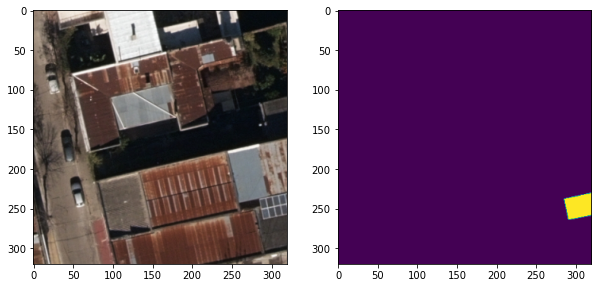

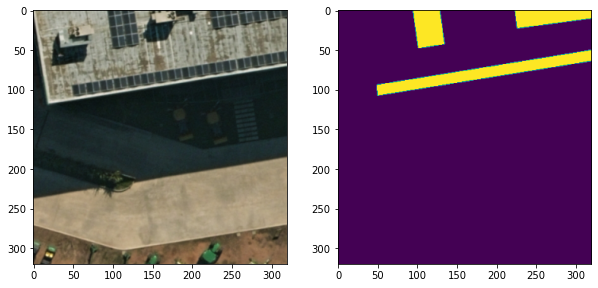

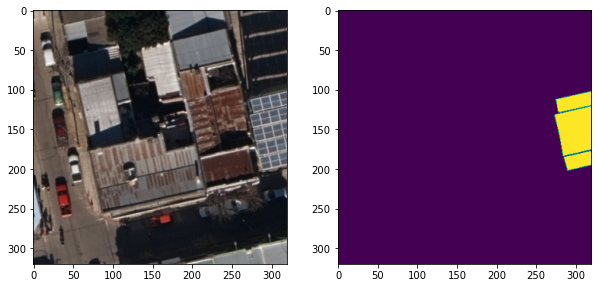

In [6]:
plot_data_generator(train_config=config, num_samples=3, fig_size=(10,10))

Ejecuta el entrenamiento

In [4]:
res = train(config)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 320, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 160, 160, 32) 0           conv2d_2[0][0]                 


Epoch 1/15
100/100 [==============================] - 69s 689ms/step - loss: 0.0888 - accuracy: 0.9530 - mean_iou: 0.3506 - val_loss: 0.0480 - val_accuracy: 0.9695 - val_mean_iou: 0.3646

Epoch 00001: val_loss improved from inf to 0.04801, saving model to data/paneles/weights/paneles_m1_v1.h5
Epoch 2/15
100/100 [==============================] - 60s 601ms/step - loss: 0.0139 - accuracy: 0.9771 - mean_iou: 0.6369 - val_loss: 0.0562 - val_accuracy: 0.9617 - val_mean_iou: 0.1761

Epoch 00002: val_loss did not improve from 0.04801
Epoch 3/15
100/100 [==============================] - 59s 594ms/step - loss: 0.0100 - accuracy: 0.9791 - mean_iou: 0.7208 - val_loss: 0.0271 - val_accuracy: 0.9700 - val_mean_iou: 0.4977

Epoch 00003: val_loss improved from 0.04801 to 0.02712, saving model to data/paneles/weights/paneles_m1_v1.h5
Epoch 4/15
100/100 [==============================] - 59s 594ms/step - loss: 0.0072 - accuracy: 0.9806 - mean_iou: 0.7661 - val_loss: 0.0102 - val_accuracy: 0.9796 - va

Para cada epoch, se imprimen las siguientes métricas:
* `loss`: *pérdida* o error sobre el dataset de entrenamiento, en este caso es la *binary cross entropy*, muy utilizada para clasificadores. Ver [más información](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a).
* `accuracy`: precisión, proporción de aciertos (TPs y TNs) sobre el total.
* `mean_iou`: promedio de la Intersección sobre Unión (IoU), métrica muy utilizada en problemas de segmentación semántica. También conocido como [índice de Jaccard](https://en.wikipedia.org/wiki/Jaccard_index).

Estas métricas se calculan primero sobre el datset de entrenamiento, y al terminar un epoch, se calculan sobre el dataset de validación (ver valores de las métricas cuyo nombre empieza con `val_`).

Podemos graficar algunas de estas métricas para visualizar mejor como el modelo fue mejorando. Lo importante es ver que el error converge a un valor y el error en validación no es mucho mayor que el de entrenamiento (van a la par). Si fuera mayor, se dice que el modelo sobreajusta (*overfitting*) y nos termina quedando un modelo que predice bien sobre el dataset de entrenamiento pero no sobre nuevos datos.

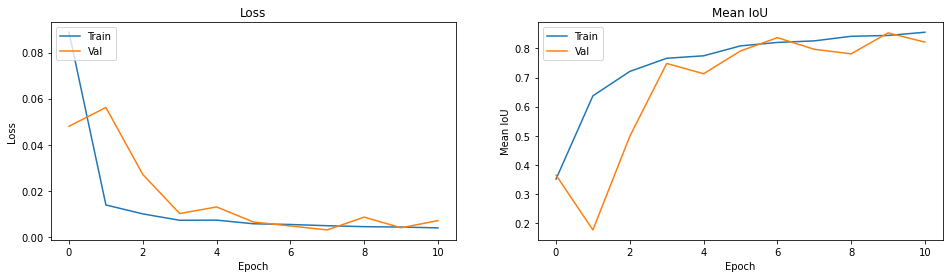

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(res.history['mean_iou'])
plt.plot(res.history['val_mean_iou'])
plt.title('Mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

En el siguiente paso entrenamos el modelo 2. Estos son los parámetros que encontramos óptimos.

In [17]:
# Modelo 2: Nacional
config = TrainConfig(width=160,
                     height=160,
                     n_channels=3,
                     n_classes=1,
                     apply_image_augmentation=True,
                     epochs=30,
                     batch_size=64,
                     steps_per_epoch=300,
                     early_stopping_patience=5,
                     validation_split=0.05,
                     images_path=os.path.join(DATA_DIR, 'train', 'national', '160_40'),
                     model_path=os.path.join(DATA_DIR, 'weights', 'paneles_m2b_v3.h5'),
                     evaluate=False)

Notar que en este caso width y height es (160, 160), dado que los chips que generamos para la imagen nacional son de ese tamaño. De esta manera no es necesario achicar o agrandar la imagen, haciendo que todo el proceso sea más eficiente, y además permite procesar el doble de imágenes por batch (64).

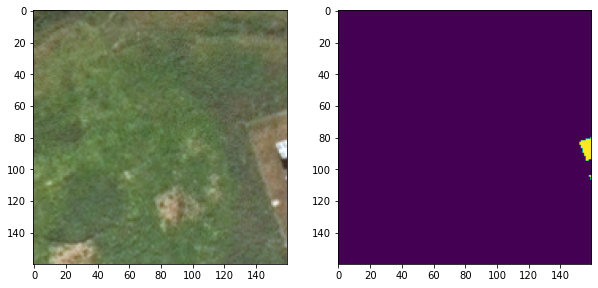

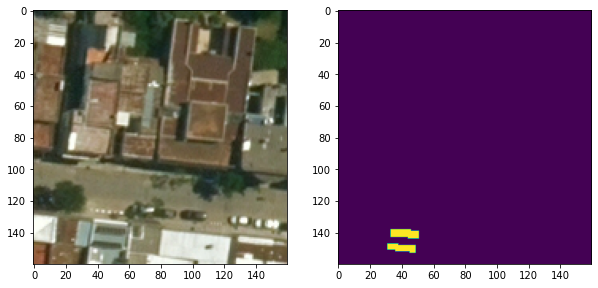

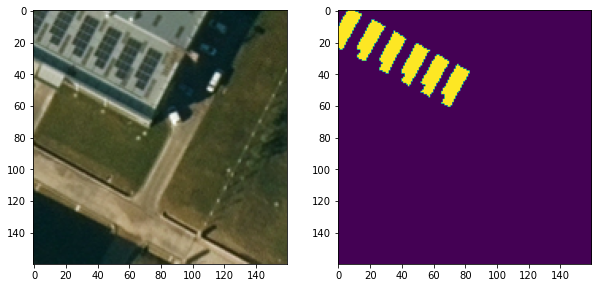

In [16]:
plot_data_generator(train_config=config, num_samples=3, fig_size=(10,10))

In [18]:
res = train(config)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 160, 160, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 160, 160, 32) 9248        conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 80, 80, 32)   0           conv2d_25[0][0]                  
____________________________________________________________________________________________

Epoch 1/30
300/300 [==============================] - 127s 424ms/step - loss: 0.0711 - accuracy: 0.9705 - mean_iou: 0.3275 - val_loss: 0.0320 - val_accuracy: 0.9783 - val_mean_iou: 0.4064

Epoch 00001: val_loss improved from inf to 0.03195, saving model to data/paneles/weights/paneles_m2b_v3.h5
Epoch 2/30
300/300 [==============================] - 111s 370ms/step - loss: 0.0202 - accuracy: 0.9851 - mean_iou: 0.4945 - val_loss: 0.0214 - val_accuracy: 0.9830 - val_mean_iou: 0.5452

Epoch 00002: val_loss improved from 0.03195 to 0.02137, saving model to data/paneles/weights/paneles_m2b_v3.h5
Epoch 3/30
300/300 [==============================] - 116s 385ms/step - loss: 0.0158 - accuracy: 0.9879 - mean_iou: 0.5555 - val_loss: 0.0222 - val_accuracy: 0.9816 - val_mean_iou: 0.5097

Epoch 00003: val_loss did not improve from 0.02137
Epoch 4/30
300/300 [==============================] - 115s 384ms/step - loss: 0.0132 - accuracy: 0.9898 - mean_iou: 0.5939 - val_loss: 0.0148 - val_accuracy: 0.9902

Nuevamente graficamos las métricas. Notar que los valores de las métricas en validación fluctuan más que en entrenamiento. Esto en general es así, dado que el datset de validación suele ser mucho más chico que el de entrenamiento, y esto implica que hay menos estadística.

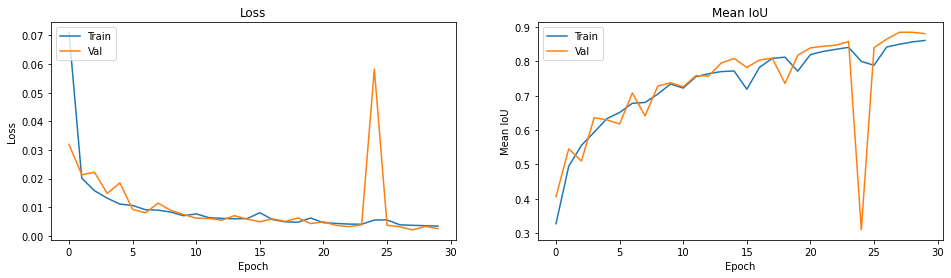

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(res.history['loss'])
plt.plot(res.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(122)
plt.plot(res.history['mean_iou'])
plt.plot(res.history['val_mean_iou'])
plt.title('Mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()